In [1]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

#####################################


ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Load the dataset from the csv file using pandas 
train = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/train.csv")
test = pd.read_csv("/cs/studres/ID5059/Coursework/Coursework-2/data/test.csv")

In [3]:
# set id as index
train = train.set_index('id')
test = test.set_index('id')

# split train set into X_train, y_train
X_train = train.drop('Class', axis = 1)
y_train = train['Class']

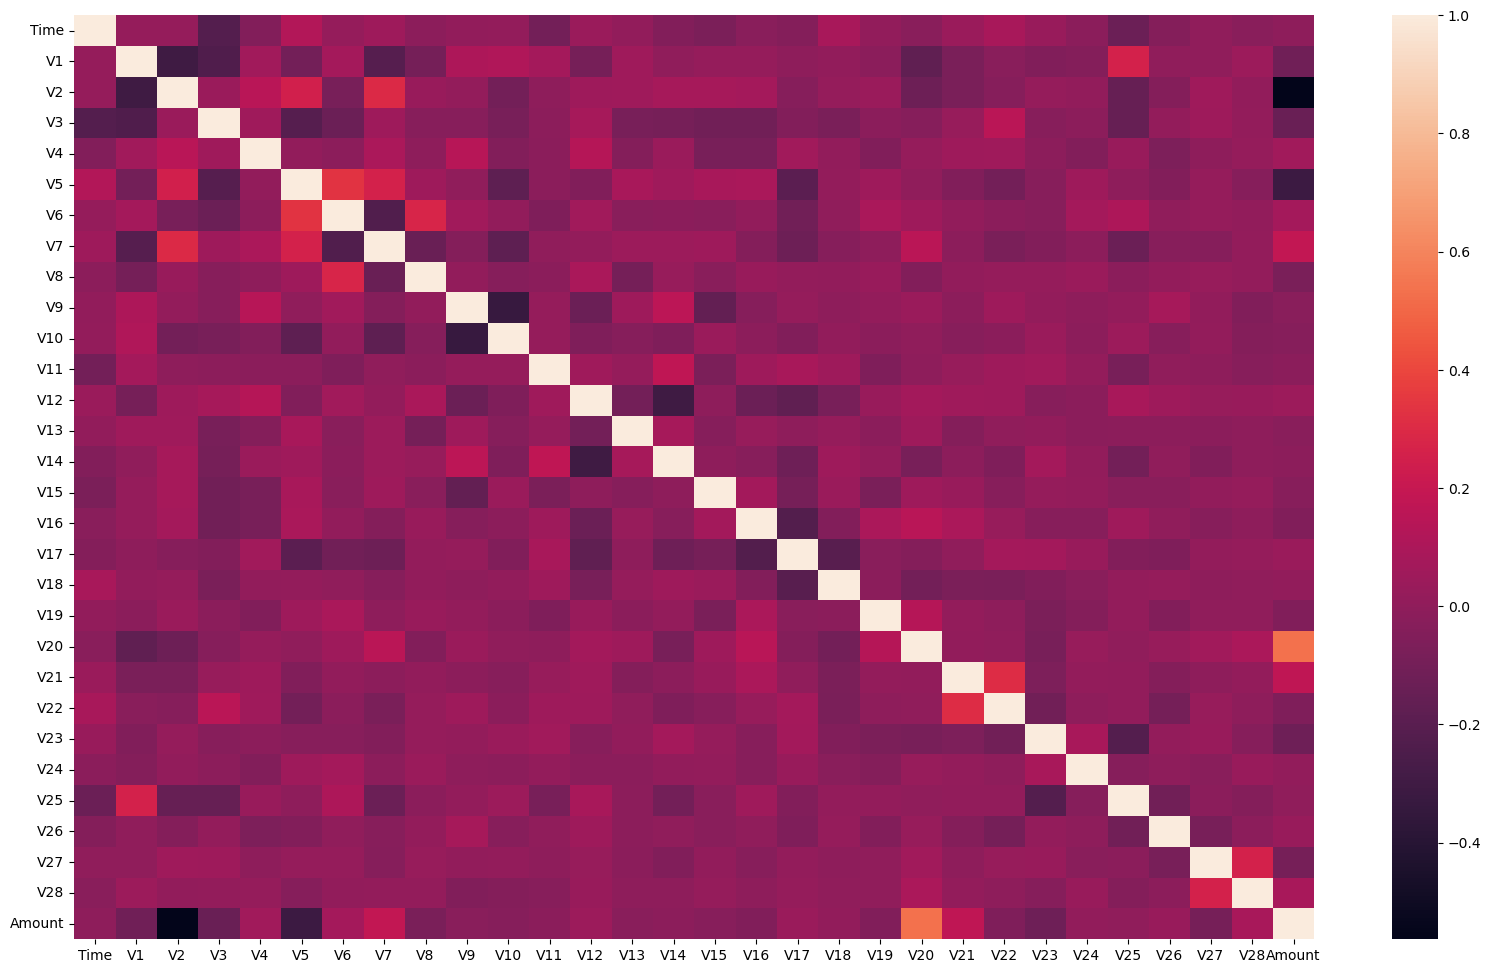

In [4]:
# dropping the target column
df_features = train.drop(columns='Class')

# plotting
plt.figure(figsize=(20,12))
sns.heatmap(df_features.corr(), annot=False)
plt.show()

In [6]:
print(train.shape)
# (219129, 31)

# Fraud and genuine datasamples
total = len(train)
fraud = train[train['Class'] == 1]
valid = train[train['Class'] == 0] 
fraud_percentage = round(len(fraud)/total*100, 8)

print('Fraud Cases: {}'.format(len(fraud)))
print('Genuine Transactions: {}'.format(len(valid))) 
print('Percentage of fraud Transactions is {}'.format(fraud_percentage))


# Fraud Cases: 469
# Genuine Transactions: 218660
# The above numbers show that about 98% of the transactions are genuine. 
# Any model trained directly on this data will inherently be biased toward the positive class 
# (genuine transactions or non-fraud transactions). 
# We will manipulate this dataset to make our model unbiased toward any categories. 
# We will build two different models here to demonstrate the effect of unbalanced-ness 
# and show how accounting for this will improve the model's performance.

(219129, 31)
Fraud Cases: 469
Genuine Transactions: 218660
Percentage of fraud Transactions is 0.21402918


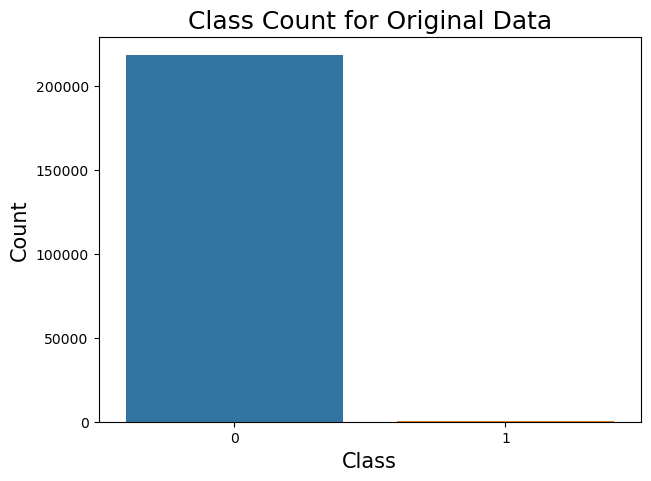

In [15]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
plt.figure(figsize = (7,5))
sns.countplot(x = 'Class', data = train)
plt.title("Class Count for Original Data", fontsize = 18)
plt.xlabel("Class", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

In [8]:
# import SMOTE and RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [9]:
# use smote to balance the data
# apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='minority')
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# apply random undersampling to balance the class distribution
rus = RandomUnderSampler(sampling_strategy='majority')
X_train_bal, y_train_bal = rus.fit_resample(X_train_bal, y_train_bal)

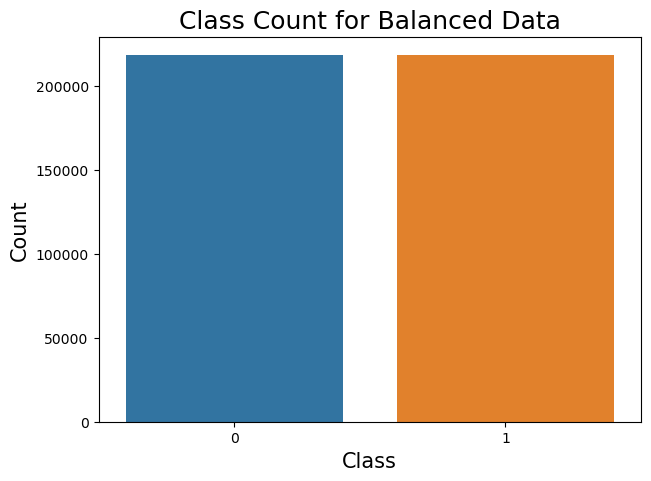

In [16]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations after the data is balanced
plt.figure(figsize = (7, 5))
sns.countplot(x = y_train_bal)
plt.title("Class Count for Balanced Data", fontsize = 18)
plt.xlabel("Class", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

In [10]:
# Start up XGBoost
xgb = XGBClassifier()

In [11]:
# Create a grid of parameters
param_grid = {
    'max_depth': [6, 12],
    'learning_rate': [0.002, 0.01, 0.02, 0.1, 0.2],
    'subsample': [0.4, 0.6, 0.8],
    'colsample_bytree': [0.4, 0.8],
    'n_estimators': [2000, 5000],
    'tree_method':['gpu_hist']}

In [24]:
from sklearn.model_selection import RandomizedSearchCV

# Use randomisedsearchcv to efficently tune our hyper-parameters
rs_xgb = RandomizedSearchCV(xgb, param_grid, n_iter = 5, n_jobs = -1, verbose= 20, cv = 3, scoring='roc_auc',
                            refit=False, random_state = 12)

In [25]:
# fit xgb model with imbalanced data
rs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/chrischan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chrischan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chrischan/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/Users/chrischan/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py", line 1490, in fit
    self._Booster = train(
  File "/Users

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=100, n_jobs=None,
                     

In [22]:
# Print the best parameters for imbalanced data
rs_xgb.best_params_

{'tree_method': 'gpu_hist',
 'subsample': 0.6,
 'n_estimators': 2000,
 'max_depth': 12,
 'learning_rate': 0.02,
 'colsample_bytree': 0.4}

In [26]:
# Create our parameters for our XGBOOST model
# We make sure to enable the GPU to run much fuster on colab
# We use the parameters from the RandomisedSearchCV above
xgb_clf = XGBClassifier(
    n_estimators=2000,
    max_depth=12,
    learning_rate=0.02,
    subsample=0.6,
    colsample_bytree=0.4,
    random_state=42, 
    tree_method='hist'  # supported by the CPU version of XGBoost.
)

In [27]:
# Fit the model to imbalanced data
xgb_imbal = xgb_clf.fit(X_train, y_train)

In [28]:
# Fit the model to balanced data
xgb_bal = xgb_clf.fit(X_train_bal, y_train_bal)

In [29]:
xgb_imbal_yhat = xgb_imbal.predict_proba(test)
xgb_bal_yhat = xgb_bal.predict_proba(test)
display(xgb_imbal_yhat, xgb_bal_yhat)

array([[9.9997509e-01, 2.4895215e-05],
       [9.9986404e-01, 1.3595686e-04],
       [9.9998307e-01, 1.6917622e-05],
       ...,
       [9.9967980e-01, 3.2018378e-04],
       [9.9999315e-01, 6.8556051e-06],
       [9.9999547e-01, 4.5543193e-06]], dtype=float32)

array([[9.9997509e-01, 2.4895215e-05],
       [9.9986404e-01, 1.3595686e-04],
       [9.9998307e-01, 1.6917622e-05],
       ...,
       [9.9967980e-01, 3.2018378e-04],
       [9.9999315e-01, 6.8556051e-06],
       [9.9999547e-01, 4.5543193e-06]], dtype=float32)

In [31]:
xgb_imbal_yhat_fraud_prob = xgb_imbal_yhat[:,1] # the first class in 0 and the second class is 1, we need to extract 1.
xgb_bal_yhat_fraud_prob = xgb_bal_yhat[:,1]

[CV 2/3; 1/5] START colsample_bytree=0.4, learning_rate=0.02, max_depth=12, n_estimators=2000, subsample=0.6, tree_method=gpu_hist
[CV 2/3; 1/5] END colsample_bytree=0.4, learning_rate=0.02, max_depth=12, n_estimators=2000, subsample=0.6, tree_method=gpu_hist;, score=nan total time=   1.5s
[CV 1/3; 5/5] START colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=2000, subsample=0.4, tree_method=gpu_hist
[CV 1/3; 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=2000, subsample=0.4, tree_method=gpu_hist;, score=nan total time=   1.3s
[CV 2/3; 3/5] START colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=2000, subsample=0.8, tree_method=gpu_hist
[CV 2/3; 3/5] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=2000, subsample=0.8, tree_method=gpu_hist;, score=nan total time=   1.4s
[CV 2/3; 5/5] START colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=2000, subsample=0.4, tree_method=gpu_hist
[

[CV 1/3; 3/5] START colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=2000, subsample=0.8, tree_method=gpu_hist
[CV 1/3; 3/5] END colsample_bytree=0.4, learning_rate=0.02, max_depth=6, n_estimators=2000, subsample=0.8, tree_method=gpu_hist;, score=nan total time=   1.5s
[CV 2/3; 4/5] START colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=5000, subsample=0.4, tree_method=gpu_hist
[CV 2/3; 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=5000, subsample=0.4, tree_method=gpu_hist;, score=nan total time=   1.2s
[CV 2/3; 2/5] START colsample_bytree=0.8, learning_rate=0.02, max_depth=12, n_estimators=2000, subsample=0.6, tree_method=gpu_hist
[CV 2/3; 2/5] END colsample_bytree=0.8, learning_rate=0.02, max_depth=12, n_estimators=2000, subsample=0.6, tree_method=gpu_hist;, score=nan total time=   1.5s
[CV 1/3; 5/5] START colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=2000, subsample=0.4, tree_method=gpu_hist
[CV

In [34]:
xgb_imbal_results_df = pd.DataFrame({'id' : test.index, 'Class' : xgb_imbal_yhat_fraud_prob})
xgb_bal_results_df = pd.DataFrame({'id' : test.index, 'Class' : xgb_bal_yhat_fraud_prob})

In [35]:
# export as csv file
xgb_imbal_results_df.to_csv('xgb_imbal_prob_results_imbal.csv', index = False)
xgb_bal_results_df.to_csv('xgb_bal_prob_results_imbal.csv', index = False)

In [ ]:
# balanced score : 0.6893; imbalanced score: 0.7497